In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import pandas as pd
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [2]:
data=pd.read_csv('datasets/malicious_data_generated.csv')
npdata=data.to_numpy()
malData=np.copy(npdata)
print(type(malData[1,:]))
print(malData[:1].shape)

<class 'numpy.ndarray'>
(1, 10)


In [3]:
class MalwareEnv():
    def __init__(self):
        # Actions we can take, decrease, increse, none
        self.action_space = Discrete(21)
        # max-min array
        self.observation_space = Box(np.asarray([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]),np.asarray([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))
        # Set start 
        self.state = np.asarray(malData[random.randint(0,499),:])
        
        # Set time 
        self.length = 60
        
    def step(self, action):
        # Apply action for each state
        if(action<10):
            if(action==0):
                self.state[0]=self.state[0]+1
            elif(action==1):
                 self.state[1]=self.state[1]+1
            elif(action==2):
                 self.state[2]=self.state[2]+1
            elif(action==3):
                 self.state[3]=self.state[3]+1
            elif(action==4):
                 self.state[4]=self.state[4]+1
            elif(action==5):
                 self.state[5]=self.state[5]+1
            elif(action==6):
                 self.state[6]=self.state[6]+1
            elif(action==7):
                 self.state[7]=self.state[7]+1
            elif(action==8):
                 self.state[8]=self.state[8]+1
            else:
                 self.state[9]=self.state[9]+1                     
        else:
            if(action==10):
                self.state[0]+=self.state[0]-1
            elif(action==11):
                 self.state[1]+=self.state[1]-1
            elif(action==12):
                 self.state[2]+=self.state[2]-1
            elif(action==13):
                 self.state[3]+=self.state[3]-1
            elif(action==14):
                 self.state[4]+=self.state[4]-1
            elif(action==15):
                 self.state[5]+=self.state[5]-1
            elif(action==16):
                 self.state[6]+=self.state[6]-1
            elif(action==17):
                 self.state[7]+=self.state[7]-1
            elif(action==18):
                 self.state[8]+=self.state[8]-1
            else:
                 self.state[9]+=self.state[9]-1  
        
        self.length -= 1 
            
        
        # Calculate reward in ranges
        rewardMulti=0 
        
        if(self.state[0]>=-0.290698 and self.state[0]<=-133.441860):
                 rewardMulti=rewardMulti+1
        elif(self.state[1]>=0 and self.state[1]<=1184):
                 rewardMulti=rewardMulti+1
        elif(self.state[2]>=-0.666667 and self.state[2]<=10.666667):
                 rewardMulti=rewardMulti+1
        elif(self.state[3]>=-0.312383 and self.state[3]<=109.259173):
                 rewardMulti=rewardMulti+1
        elif(self.state[4]>=0 and self.state[4]<=30):
                 rewardMulti=rewardMulti+1
        elif(self.state[5]>=-0.322 and self.state[5]<=127.488889):
                 rewardMulti=rewardMulti+1
        elif(self.state[6]>=-0.282353 and self.state[6]<=147.976471):
                 rewardMulti=rewardMulti+1
        elif(self.state[7]>=-0.164688 and self.state[7]<=715.616633):
                 rewardMulti=rewardMulti+1
        elif(self.state[8]>=-0.324081 and self.state[8]<=106.407677):
                 rewardMulti=rewardMulti+1
        elif(self.state[9]>=-0.750000 and self.state[9]<=227.5):
                 rewardMulti=rewardMulti+1
                 
        if(rewardMulti==0):
            reward=-1
        else:
            reward=rewardMulti
                 
        
        # Check if is done
        if self.length <= 0: 
            done = True
        else:
            done = False
        
        
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        pass
    
    def reset(self):
        # Reset 
        self.state = malData[random.randint(0,499),:]
        # Reset time
        self.length = 60 
        return self.state

episode: 0/25, score: 20.0
episode: 1/25, score: 26.0
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
episode: 2/25, score: 57.0
episode: 3/25, score: 39.0
episode: 4/25, score: 16.0
episode: 5/25, score: 13.0
episode: 6/25, score: 9.0
episode: 7/25, score: 12.0
episode: 8/25, score: 11.0
episode: 9/25, score: 16.0
episode: 10/25, score: 9.0
episode: 11/25, score: 22.0
episode: 12/25, score: 10.0
episode: 13/25, score: 9.0
episode: 14/25, score: 10.0
episode: 15/25, score: 8.0
episode: 16/25, score: 11.0
episode: 17/25, score: 9.0
episode: 18/25, score: 11.0
episode: 19/25, score: 21.0
episode: 20/25, score: 17.0
episode: 21/25, score: 22.0
episode: 22/25, score: 17.0
episode: 23/25, score: 24.0
episode: 24/25, score: 33.0


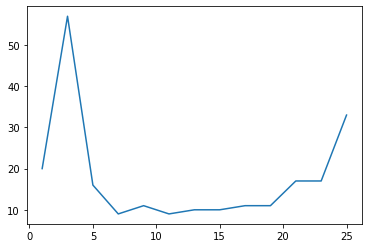

In [4]:
import gym
import random
from tensorflow.keras import Sequential
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import numpy as np
env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)


class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.epsilon_decay = .995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=10000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(24, input_shape=(self.state_space,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def train_dqn(episode):

    loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 4))
        score = 0
        max_steps = 1000
        for i in range(max_steps):
            env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 4))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)
    return loss


def random_policy(episode, step):

    for i_episode in range(episode):
        env.reset()
        for t in range(step):
            env.render()
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
            print("Starting next episode")


if __name__ == '__main__':

    ep = 25
    loss = train_dqn(ep)
    plt.plot([i+1 for i in range(0, ep, 2)], loss[::2])
    plt.show()